<img src=../figures/Brown_logo.svg width=50%>

## Data-Driven Design & Analyses of Structures & Materials (3dasm)

## Lecture 16

### Miguel A. Bessa | <a href = "mailto: miguel_bessa@brown.edu">miguel_bessa@brown.edu</a>  | Associate Professor

**What:** A lecture of the "3dasm" course

**Where:** This notebook comes from this [repository](https://github.com/bessagroup/3dasm_course)

**Reference for entire course:** Murphy, Kevin P. *Probabilistic machine learning: an introduction*. MIT press, 2022. Available online [here](https://probml.github.io/pml-book/book1.html)

**How:** We try to follow Murphy's book closely, but the sequence of Chapters and Sections is different. The intention is to use notebooks as an introduction to the topic and Murphy's book as a resource.
* If working offline: Go through this notebook and read the book.
* If attending class in person: listen to me (!) but also go through the notebook in your laptop at the same time. Read the book.
* If attending lectures remotely: listen to me (!) via Zoom and (ideally) use two screens where you have the notebook open in 1 screen and you see the lectures on the other. Read the book.

**Optional reference (the "bible" by the "bishop"... pun intended 😆) :** Bishop, Christopher M. *Pattern recognition and machine learning*. Springer Verlag, 2006.

**References/resources to create this notebook:**
* This simple tutorial is still based on a script I created for this article: https://imechanica.org/node/23957
* It follows from some examples provided by the scikit-learn user guide, which seem to have originated from Mathieu Blondel, Jake Vanderplas, Vincent Dubourg, and Jan Hendrik Metzen.
* Creating a new StandardScaler for Gaussian Processes: https://stats.stackexchange.com/questions/364418/how-to-get-the-prediction-std-using-gaussian-process-in-scikit-learn

## **OPTION 1**. Run this notebook **locally in your computer**:
1. Confirm that you have the '3dasm' mamba (or conda) environment (see Lecture 1).
2. Go to the 3dasm_course folder in your computer and pull the last updates of the [repository](https://github.com/bessagroup/3dasm_course):
```
git pull
```
    - Note: if you can't pull the repo due to conflicts (and you can't handle these conflicts), use this command (with **caution**!) and your repo becomes the same as the one online:
        ```
        git reset --hard origin/main
        ```
3. Open command window and load jupyter notebook (it will open in your internet browser):
```
jupyter notebook
```
5. Open notebook of this Lecture and choose the '3dasm' kernel.

## **OPTION 2**. Use **Google's Colab** (no installation required, but times out if idle):

1. go to https://colab.research.google.com
2. login
3. File > Open notebook
4. click on Github (no need to login or authorize anything)
5. paste the git link: https://github.com/bessagroup/3dasm_course
6. click search and then click on the notebook for this Lecture.

In [1]:
# Basic plotting tools needed in Python.

import matplotlib.pyplot as plt # import plotting tools to create figures
import numpy as np # import numpy to handle a lot of things!
from IPython.display import display, Math # to print with Latex math

%config InlineBackend.figure_format = "retina" # render higher resolution images in the notebook
plt.rcParams["figure.figsize"] = (8,4) # rescale figure size appropriately for slides

## Outline for today

* Model selection and hyperparameter determination in machine learning
    - Bayesian Model selection
    - Type II maximum likelihood (maximizing the log marginal likelihood)

**Reading material**: This notebook + (Sections 4.6.5 and 17.2.6 of Murphy's book) + (Sections 5.2, 5.3 and 5.4 of [Rasmussen book](https://gaussianprocess.org/gpml/chapters/RW.pdf))

Note: I particularly like Rasmussen's chapter 5, and this notebook is mostly based on that.

## Bayesian Model selection

The Bayesian perspective provides a very general strategy for **Model selection** in machine learning.

In this view, there is a hierarchical specification of models.
* At the **first (bottom) level** are the parameters $\mathbf{z}$

* At the **second (intermediate) level** are the hyperparameters $\boldsymbol{\theta}$

* At the **last (top) level** is a (discrete) set of possible model structures $\mathcal{M}_i$

### Examples of hierarchical specification of models

**First (bottom) level** with parameters $\mathbf{z}$:
* Example: weights and biases of a linear regression model with a polynomial basis. Note: Gaussian processes do not have "parameters" (only hyperapameters).

**Second (intermediate) level** with hyperparameters $\boldsymbol{\theta}$:
* Example: pior variance (a.k.a. regularization term) in Ridge regression. Another example: kernel parameters in Gaussian processes such as the length scale of RBF kernel.

**Last (top) level** with (discrete) model structures $\mathcal{M}_i$ (sometimes also simply called models):
* Example: the choice of basis functions in linear least squares, such as $\mathcal{M}_1$ being a model with a quadratic polynomial and $\mathcal{M}_2$ with a cubic polynomial. Another example: the choice of kernel in Gaussian process regression, where each $\mathcal{M}_i$ could be a kernel choice.
    - Note: even entirely different models could be considered, where $\mathcal{M}_1$ could be a linear regression model, $\mathcal{M}_2$ could be Gaussian process regression, etc.

Hierarchical specification of models means to do Bayesian inference one level at a time, just like we did before for the parameters! So, the bottom level is characterized by finding the posterior over the parameters $\mathbf{z}$:

$$
p(\mathbf{z}|\mathcal{D}, \boldsymbol{\theta}, \mathcal{M}_i) = \frac{p(\mathcal{D}|\mathbf{z},\mathcal{M}_i) p(\mathbf{z}|\boldsymbol{\theta},\mathcal{M}_i)}{p(\mathcal{D}|\boldsymbol{\theta},\mathcal{M}_i)}
$$

Note that we are using the notation we introduced previously where $\mathcal{D}=\{\mathcal{D}_x,\mathcal{D}_x\}$ is the data. For completeness, in the notes below I write the same expression but explicitly including $\mathbf{y}$ and $\mathbf{x}$.

#### A note about notation

In Bayesian machine learning there are many entities we have to keep track of (variables, parameters, hyperparameters, discrete model structures, etc.).

The notation can vary for different books (and even within the same book...). In this course, I try our best to keep consistency.

One nice trick is to refer to the data by $\mathcal{D}$ because in this way, as we will see later in the course, everything we do now generalizes for the unsupervised learning case, like the supervised learning case we have been focusing so far in the course.

The expression in the previous cell for a case where we consider pairs of input $\mathbf{X}\equiv X_{ni}$ and output $\mathbf{y}\equiv y_n$ data (as happens in regression) can also be written as:

$$
p(\mathbf{z}|\mathbf{y}=\mathcal{D}_y, \mathbf{X}=\mathcal{D}_x, \boldsymbol{\theta}, \mathcal{M}_i) = \frac{p(\mathbf{y}=\mathcal{D}_y|\mathbf{X}=\mathcal{D}_x, \mathbf{z},\mathcal{M}_i) p(\mathbf{z}|\boldsymbol{\theta},\mathcal{M}_i)}{p(\mathbf{y}=\mathcal{D}_y|\mathbf{X}=\mathcal{D}_x,\boldsymbol{\theta},\mathcal{M}_i)}
$$

where we recall that the input matrix $\mathbf{X}\equiv X_{ni}$ has $n=1,\ldots,N$ data points and $i=1,\ldots,D){\text{in}}$ input dimensions (features), and that the output vector $\mathbf{y}\equiv y_n$ has the same number of data points (of course) but is being assumed to be one dimensional (without loss of generality, because you can always write the output data as a matrix $\mathbf{Y}\equiv Y_{nj}$ where $j=1,\ldots,D_{\text{out}}$ with $D_{\text{out}}$ being the number of outputs or target variables).

This is why it is so convenient to just write the data as $\mathcal{D}$, as the data can assume many forms!

## First (bottom) level: Posterior over the paramaters $\mathbf{z}$

$$
p(\mathbf{z}|\mathcal{D}, \boldsymbol{\theta}, \mathcal{M}_i) = \frac{p(\mathcal{D}|\mathbf{z},\mathcal{M}_i) p(\mathbf{z}|\boldsymbol{\theta},\mathcal{M}_i)}{p(\mathcal{D}|\boldsymbol{\theta},\mathcal{M}_i)}
$$

* $p(\mathcal{D}|\mathbf{z},\mathcal{M}_i)$ is the likelihood.
* $p(\mathbf{z}|\boldsymbol{\theta},\mathcal{M}_i)$ is the parameter prior.
* $p(\mathcal{D}|\boldsymbol{\theta},\mathcal{M}_i)$ is the marginal likelihood (normalization constant).

Note that previously we omitted the hyperparamaters $\boldsymbol{\theta}$ because we asssumed them to be fixed, and we didn't even talk about specific models $\mathcal{M}_i$ because we only considered one model at a time. So, we did not write the Bayes rule explicitly on these two entities (the note below reminds you about how we wrote the Bayes rule previously).

#### Compare with how we wrote the Bayes' rule previously (fixed hyperparameters and only one model)

$$
p(\mathbf{z}|\mathcal{D}) = \frac{p(\mathcal{D}|\mathbf{z}) p(\mathbf{z})}{p(\mathcal{D})}
$$

* $p(\mathcal{D}|\mathbf{z})$ is the likelihood.
* $p(\mathbf{z})$ is the parameter prior.
* $p(\mathcal{D})$ is the marginal likelihood (normalization constant).

## First (bottom) level: Posterior over the paramaters $\mathbf{z}$

$$
p(\mathbf{z}|\mathcal{D}, \boldsymbol{\theta}, \mathcal{M}_i) = \frac{p(\mathcal{D}|\mathbf{z},\mathcal{M}_i) p(\mathbf{z}|\boldsymbol{\theta},\mathcal{M}_i)}{p(\mathcal{D}|\boldsymbol{\theta},\mathcal{M}_i)}
$$

where the marginal likelihood $p(\mathcal{D}|\boldsymbol{\theta},\mathcal{M}_i)$ is independent of the parameters $\mathbf{z}$ but depends on the hyperparameters $\boldsymbol{\theta}$ (and obviously the model choice $\mathcal{M}_i$).

As we saw several times, the marginal likelihood is independent of the parameters $\mathbf{z}$ because we marginalize them (integrate them out):

$$
p(\mathcal{D}|\boldsymbol{\theta},\mathcal{M}_i) = \int p(\mathcal{D}|\mathbf{z},\mathcal{M}_i) p(\mathbf{z}|\boldsymbol{\theta},\mathcal{M}_i) d\mathbf{z}
$$

## Second (intermediate) level: Posterior of the hyperparameters $\boldsymbol{\theta}$

However, if we wanted to take into account the different values for hyperparameters (instead of assuming them fixed), we can continue with the Bayesian inference by going up a level!

* In this next level, we aim to find the posterior over the hyperparameters $\boldsymbol{\theta}$ so that we can integrate them out as well (i.e. consider all possible $\boldsymbol{\theta}$ to get our PPD **without** explicit dependency in $\boldsymbol{\theta}$).

$$
p(\boldsymbol{\theta}|\mathcal{D}, \mathcal{M}_i) = \frac{p(\mathcal{D}|\boldsymbol{\theta},\mathcal{M}_i) p(\boldsymbol{\theta}|\mathcal{M}_i)}{p(\mathcal{D}|\boldsymbol{\theta},\mathcal{M}_i)}
$$

where the marginal likelihood from the first level is now acting as the **likelihood** of the second level!

## Second (intermediate) level: Posterior of the hyperparameters $\boldsymbol{\theta}$

$$
p(\boldsymbol{\theta}|\mathcal{D}, \mathcal{M}_i) = \frac{p(\mathcal{D}|\boldsymbol{\theta},\mathcal{M}_i) p(\boldsymbol{\theta}|\mathcal{M}_i)}{p(\mathcal{D}|\boldsymbol{\theta},\mathcal{M}_i)}
$$

The prior term $p(\boldsymbol{\theta}|\mathcal{M}_i)$ in this second level is the prior for the hyperparameters (sometimes called **hyper-prior**).

While the marginal likelihood for this second level is independent of the parameters $\boldsymbol{\theta}$ because we marginalize them (integrate them out):

$$
p(\mathcal{D}|\mathcal{M}_i) = \int p(\mathcal{D}|\boldsymbol{\theta},\mathcal{M}_i) p(\boldsymbol{\theta}|\mathcal{M}_i) d\boldsymbol{\theta}
$$

## Third (top) level: Posterior of the model $\mathcal{M}_i$

$$
p(\mathcal{M}_i|\mathcal{D}) = \frac{p(\mathcal{D}|\mathcal{M}_i) p(\mathcal{M}_i)}{p(\mathcal{D})}
$$

where, again, the likelihood of this third level is the marginal likelihood of the second level.

Note that the marginal likelihood of this third level is marginalized similarly as before but instead of an integral over all models, we need to sum over all models $\mathcal{M}_i$ because the models are **discrete** (so, integrals become sums):

$$
p(\mathcal{D}) = \sum_i p(\mathcal{D}|\mathcal{M}_i)p(\mathcal{M}_i)
$$

and where $p(\mathcal{M}_i)$ is the prior for model $\mathcal{M}_i$ (it is a probabilty, instead of a probability density because the model is discrete).

Your first encounter with a hiearchical specification of models with 3 levels can be a little intimidating.

But if you look carefully, we are just solving the Bayes' rule recursively to integrate out parameters, then hyperparameters and finally models.

To make it a little easier, let's consider the case where we have only one model (the most common case).

* Besides, if we know how to go from level 1 to level 2, we certainly know how to get to level 3

So, by assuming we have only one model, then we can forget about $\mathcal{M}_i$ and omit it from the expression of the Bayes' rule (just like we omitted the hyperparameters in previous lectures) .

## Bayesian model selection considering just 2 levels

Then, if we think about parameters and hyperparameters as rv's (unknowns), we need to consider two levels of model specification:

**Level 1** where we define the posterior over parameters (forgetting about $\mathcal{M}_i$):

$$
p(\mathbf{z}|\mathcal{D}, \boldsymbol{\theta}) = \frac{p(\mathcal{D}|\mathbf{z}) p(\mathbf{z}|\boldsymbol{\theta})}{p(\mathcal{D}|\boldsymbol{\theta})}
$$

where the marginal likelihood for level 1 is: $p(\mathcal{D}|\boldsymbol{\theta}) = \int p(\mathcal{D}|\mathbf{z}) p(\mathbf{z}|\boldsymbol{\theta}) d\mathbf{z}$

And **Level 2** where we determine the posterior over hyperparameters:

$$
p(\boldsymbol{\theta}|\mathcal{D}) = \frac{p(\mathcal{D}|\boldsymbol{\theta}) p(\boldsymbol{\theta})}{p(\mathcal{D})}
$$

where the marginal likelihood for level 2 is: $p(\mathcal{D}) = \int p(\mathcal{D}|\boldsymbol{\theta}) p(\boldsymbol{\theta}) d\boldsymbol{\theta}$

*(Let's write on the blackboard these two levels)*

However, this involves calculating multiple integrals...

Even when considering only one level (i.e. considering fixed hyperparameters), it's usually difficult or impossible to solve the integrals analytically...

Furthermore, even if we wanted to calculate these integrals numerically, in practice it is difficult to calculate them efficiently (we need to use techniques like Markov Chain Monte Carlo, among others).

* Conclusion: So, if you found Bayesian inference difficult for one level, let alone doing it for a second level!

The notes below highlight this difficulty when applied to Gaussian processes.

#### Note about two level model specification for Gaussian process regression

* Stop for a moment and think about Gaussian Process regression.
    - We saw that for level 1 Bayesian inference (for fixed hyperparamters) we could calculate everything analytically (all the way until getting a PPD).
    - But now imagine that you allow the hyperparameters to change: our life becomes difficult! For example, think about the RBF kernel:

$$
k(x_i,x_j) = {\color{red}s}^2\exp{\left(-\frac{||x_i-x_j||^2}{2{\color{red}l}^2}\right)}
$$

and then remember that the pdfs and likelihoods that we need until reaching the PPD depend on the kernel.

But the kernel depends on the hyperparameters nonlinearly (see $l$). Still, you need to group the kernel into a kernel vector and a kernel matrix (to calculate the likelihoods for your data), invert the kernel matrix, do various multiplications and still be able to compute two integrals (marginal likelihood for level 2 and corresponding PPD)!

No wonder that we usually do not go "full Bayesian" and integrate out the hyperparameters! It's very tricky to calculate those integrals for Level 2...

## What can we do?

If we cannot easily marginalize (integrate out) the hyperparameters to obtain the best machine learning model...

* What did we do when we found it difficult to calculate the integral that gives us the PPD?

**Point estimates!**

## Simplified Bayesian model selection: point estimates

The simplest point estimate we saw bebfore?

* Maximum likelihood estimate (MLE)

But now we need to determine the MLE for the posterior over the hyperparameters:

$$
p(\boldsymbol{\theta}|\mathcal{D}) = \frac{p(\mathcal{D}|\boldsymbol{\theta}) p(\boldsymbol{\theta})}{p(\mathcal{D})}
$$

Since this is done at level 2, we call this point estimate: **Type II Maximum Likelihood estimate (MLE-II)**

$$
p(\boldsymbol{\theta}|\mathcal{D}) = \frac{p(\mathcal{D}|\boldsymbol{\theta}) p(\boldsymbol{\theta})}{p(\mathcal{D})}
$$

If we use maximum likelihood (of type II), what prior are we assuming on the hyperparameters $p(\boldsymbol{\theta})$?

* Uniform prior!

So, finding the maximum location of the posterior over the hyperparameters:

$$\begin{align}
\hat{\boldsymbol{\theta}}_{MLE-II} =& \underset{\boldsymbol{\theta}}{\mathrm{argmax}}\left[p(\boldsymbol{\theta}|\mathcal{D}) \right] \\
=& \underset{\boldsymbol{\theta}}{\mathrm{argmax}} \left[\log{p(\boldsymbol{\theta}|\mathcal{D})} \right]\\
=& \underset{\boldsymbol{\theta}}{\mathrm{argmax}} \left[ \log{p(\mathcal{D}|\boldsymbol{\theta}) + \underbrace{\log{p(\boldsymbol{\theta})}}_{constant} - \underbrace{\log{p(\mathcal{D})}}_{constant}} \right] \\
\end{align}
$$

Conclusion: The MLE-II is the same as locating the maximum of...?

* ... the **marginal likelihood of level 1**, i.e. $p(\mathcal{D}|\boldsymbol{\theta})$

It is quite remarkable the simplicity of the result we found!

$$\begin{align}
\hat{\boldsymbol{\theta}}_{MLE-II} =& \underset{\boldsymbol{\theta}}{\mathrm{argmax}} \; \log{p(\mathcal{D}|\boldsymbol{\theta})} \\
=& \underset{\boldsymbol{\theta}}{\mathrm{argmin}} \left[ -\log{p(\mathcal{D}|\boldsymbol{\theta})}\right] \\
=& \underset{\boldsymbol{\theta}}{\mathrm{argmax}} \; p(\mathcal{D}|\boldsymbol{\theta}) \\
\end{align}
$$

where $p(\mathcal{D}|\boldsymbol{\theta}) = \int p(\mathcal{D}|\mathbf{z}) p(\mathbf{z}|\boldsymbol{\theta}) d\mathbf{z}$ is a term we have calculated many times before (and for different models!).

So, we can find "optimal" hyperparameters by maximizing the **marginal likelihood** (of level 1).

#### Note about referring to "levels" or not

From now on, we rarely need to refer to "levels" because we can estimate the hyperparameters without calculating additional integrals (avoiding hiearchical model specification).

Instead we will just use a point estimate for the hypereparameters (usually the simplest point estimate is used: MLE-II).

But is the MLE-II the only point estimate for the posterior over hyperparameters?

* Of course not! We can use different point estimates

For example, the Type II Maximum A Posteriori (MAP-II) estimate.

* In this case, we assume the prior of the hyperparameters to be different from the uniform distribution

For completeness, however, I want to highlight that we could have used **other point estimates** to estimate the "optimal" hyperparameters.

| Point estimate | Definition  |
|:--        |:--         |
| Maximum likelihood (MLE)  | $$\hat{\mathbf{z}}_{MLE} = \underset{\mathbf{z}}{\mathrm{argmax}} \; p(\mathcal{D}|\mathbf{z})$$ | 
| Maximum a posteriori (MAP)  | $$\hat{\mathbf{z}}_{MAP} = \underset{\mathbf{z}}{\mathrm{argmax}} \left[ p(\mathcal{D}|\mathbf{z}) p(\mathbf{z}|\boldsymbol{\theta})\right]$$ | 
| Type II maximum likelihood (MLE-II) | $$\hat{\boldsymbol{\theta}}_{MLE-II} = \underset{\mathbf{z}}{\mathrm{argmax}} \left[ \int p(\mathcal{D}|\mathbf{z}) p(\mathbf{z}|\boldsymbol{\theta}) d\mathbf{z} \right]$$ | 
| Type II maximum a posteriori (MAP-II) | $$\hat{\boldsymbol{\theta}}_{MAP-II} = \underset{\mathbf{z}}{\mathrm{argmax}} \left[ \int p(\mathcal{D}|\mathbf{z}) p(\mathbf{z}|\boldsymbol{\theta})p(\boldsymbol{\theta}) d\mathbf{z} \right]$$ |

Or, if you are feeling brave, you could go **"Full Bayesian"**, where you solve both levels and get the complete posterior distribution that marginalizes both the parameters $\mathbf{z}$ and the hyperparameters $\boldsymbol{\theta}$ (avoiding point estimates):

$$
p(\mathbf{z},\boldsymbol{\theta}|\mathcal{D}) = \frac{p(\mathcal{D}|\mathbf{z}) p(\mathbf{z}|\boldsymbol{\theta})p(\boldsymbol{\theta})}{p(\mathcal{D})}
$$

The above expression is deceivingly simple... Let's write the complete expression (where the integrals are more visible)

Here's what it means to going **"Full Bayesian"** for the posterior (in both parameters and hyperparamters):

$$\begin{align}
p(\mathbf{z},\boldsymbol{\theta}|\mathcal{D}) =& \frac{p(\mathcal{D}|\mathbf{z}) p(\mathbf{z}|\boldsymbol{\theta})p(\boldsymbol{\theta})}{p(\mathcal{D})} \\\\
=& \frac{p(\mathcal{D}|\mathbf{z}) p(\mathbf{z}|\boldsymbol{\theta})p(\boldsymbol{\theta})}{\int p(\mathcal{D}|\boldsymbol{\theta})  p(\boldsymbol{\theta}) d\boldsymbol{\theta}} \\\\
=& \frac{p(\mathcal{D}|\mathbf{z}) p(\mathbf{z}|\boldsymbol{\theta})p(\boldsymbol{\theta})}{\int \left[ \int p(\mathcal{D}|\mathbf{z}) p(\mathbf{z}|\boldsymbol{\theta}) d\mathbf{z} \right] p(\boldsymbol{\theta}) d\boldsymbol{\theta}} \\\\
=& \frac{p(\mathcal{D}|\mathbf{z}) p(\mathbf{z}|\boldsymbol{\theta})p(\boldsymbol{\theta})}{\int \int p(\mathcal{D}|\mathbf{z}) p(\mathbf{z}|\boldsymbol{\theta}) p(\boldsymbol{\theta}) d\mathbf{z} d\boldsymbol{\theta}} \\
\end{align}
$$

I know... It's a bit ugly... And remember, we could still go to level 3 😅

In addition, this is only the posterior! What we really want is the PPD (another integral)...

#### Note about determination of hyperparameters by cross-validation (instead of point estimates)

Hyperparameter can also be determined via a **non-probabilistic** strategy:

* Cross-validation

In fact, you did this for linear least squares with polynomial basis functions in Homework 4 (although, technically, the degree of the polynomial should be called a model structure because it is discrete, instead of calling it a hyperparameter).

Here's how to determine the hyperparameters by $k$-fold cross-validation:

* Split the dataset into **training** and **testing** sets. Leave the testing set untouched.

* Partition the **training** dataset in $k$ folds (partitions).

* Then use the data in $k-1$ partitions as a training set and the remaining partition as the **validation** set where you evaluate the error metric of choice (e.g. MSE).

* Then, rotate $k$ times your validation set, such that you can evaluate $k$ different models (for example, $k$ different values of the hyperparameters) and choose the best one.

## Example: Gaussian process regression (GPR)

Let's put this knowledge into practice by estimating hyperparameters with MLE-II.

In the previous lectures we determined the PPD for Gaussian process regression (here I assume zero mean for the prior over parameters):

$$\require{color}
{\color{orange}p(y^*|\mathbf{x}^*, \mathcal{D})} = \mathcal{N}\left( y^* \mid {\mathbf{k}^*}^T \mathbf{K}^{-1}\mathbf{y} \,,\, k(\mathbf{x}^*, \mathbf{x}^*) - {\mathbf{k}^*}^T \mathbf{K}^{-1} \mathbf{k}^*\right)
$$

where the kernel is typically written including noisy observations:

$$
k(\mathbf{x}_i, \mathbf{x}_j) = \sigma_i^2 \delta_{ij} + k_{\text{noiseless}}(\mathbf{x}_i, \mathbf{x}_j)
$$

for example: $k(\mathbf{x}_i, \mathbf{x}_j) = \sigma_i^2 \delta_{ij} + s^2 \exp\left( - \frac{||\mathbf{x}_i-\mathbf{x}_j||^2}{2 l^2} \right)$

However, in the previous Lectures we were missing the last piece: using a point estimate to determine the hyperparameters that lead to a good PPD (that explains the data as best as possible).

Usually, the MLE-II point estimate is used for GPR.

* So, we need to maximize the marginal likelihood for GPR.

This time I won't derive the log marginal likelihood in front of you 😉

It's the usual integration after a multiplication of Gaussians, like we did in Lecture 5 and Lecture 12. After we do that, the **log marginal likelihood** for GPR becomes:

$$
\log{p(\mathcal{D}|\boldsymbol{\theta})} = {\mathbf{y}}^T \mathbf{K}^{-1}\mathbf{y} - \frac{1}{2}\log{|\mathbf{K}|}-\frac{N}{2}\log{2\pi}
$$

where the input data points are part of the kernel matrix, and the output data points are collected in vector $\mathbf{y}$, as we discussed extensively in the previous lectures.

#### Side note: Gaining intuition for the behavior of the log marginal likelihood of GPR

Rasmussen's book has a beautiful discussion about the behavior of the log marginal likelihood for GPR (Section 5.4.1), where they break down the contribution of the three terms. Highly recommended!

Therefore, using MLE-II we get an estimate for the hyperparameters as follows:

$$\begin{align}
\hat{\boldsymbol{\theta}}_{MLE-II} =& \underset{\boldsymbol{\theta}}{\mathrm{argmax}} \; \log{p(\mathcal{D}|\boldsymbol{\theta})}\\
=& \underset{\boldsymbol{\theta}}{\mathrm{argmax}} \; \left[{\mathbf{y}}^T \mathbf{K}^{-1}\mathbf{y} - \frac{1}{2}\log{|\mathbf{K}|}-\frac{N}{2}\log{2\pi}\right]
\end{align}
$$

Up to now in the course, we have not talked about optimization algorithms.
* So, for now, just focus on the idea that you can give the above expression of the log marginal likelihood to an optimizer that will find the hyperparameter values by discovering the maximum location (or, equivalently, the location of the minimum of the negative log marginal likelihood).
    - Finding this optimum is faster if you also provide the gradient of the log marginal likelihood (that can easily be calculated analytically from the above expression)

### This concludes the theoretical discussion of Gaussian Process Regression

In summary, we have completely derived the GPR model and its typical hyperparameter optimization strategy.

$$\require{color}
{\color{orange}p(y^*|\mathbf{x}^*, \mathcal{D})} = \mathcal{N}\left( y^* \mid {\mathbf{k}^*}^T \mathbf{K}^{-1}\mathbf{y} \,,\, k(\mathbf{x}^*, \mathbf{x}^*) - {\mathbf{k}^*}^T \mathbf{K}^{-1} \mathbf{k}^*\right)
$$

where a typical kernel is:

$$
k(\mathbf{x}_i, \mathbf{x}_j) = \sigma_i^2 \delta_{ij} + s^2 \exp\left( - \frac{||\mathbf{x}_i-\mathbf{x}_j||^2}{2 l^2} \right)
$$

and where the hyperparameters would be $s$ and $l$, and where $\sigma_i$ would be an input (noise standard deviation at every observation) or another hyperparameter (if we want to determine the noise, instead of having it measured), as we saw in the last lecture.

The hyperparamters are simply determined by optimization of the log marginal likelihood (which we saw that corresponds to the MLE-II of the hyperparameter posterior):

$$\begin{align}
\hat{\boldsymbol{\theta}}_{MLE-II} =& \underset{\boldsymbol{\theta}}{\mathrm{argmax}} \; \log{p(\mathcal{D}|\boldsymbol{\theta})}\\
=& \underset{\boldsymbol{\theta}}{\mathrm{argmax}} \; \left[{\mathbf{y}}^T \mathbf{K}^{-1}\mathbf{y} - \frac{1}{2}\log{|\mathbf{K}|}-\frac{N}{2}\log{2\pi}\right]
\end{align}
$$

where $\hat{\boldsymbol{\theta}}_{MLE-II} = \begin{bmatrix} \hat{s}\\
\hat{l}\\
\end{bmatrix}$ are the optimized hyperparameters (here I assumed that the noise was an input; otherwise, if we were also learning the noise at every training point then $\hat{\boldsymbol{\theta}}_{MLE-II}$ would include every $\sigma_i$).

* As we saw in the last two lectures, the most common optimizer of the log marginal likelihood for GPR is called "L-BFGS-B". If we have time, I will teach you about it later. It's a very effective optimizer for non-stochatic landscapes and for relatively low number of dimensions (ideal for GPR!).

But how does the log marginal likelihood look like?

* It depends on the problem, of course!

* However, finding a good (local) optimum is quite trivial for GPR because this method has few hyperparameters (unlike what we will see for artificial neural networks!).

* Still, the log marginal likelihood depends on the data! If you have few training points and complicated kernels, you may have multiple local optima and finding good hyperparameters might be difficult (or even non-unique). If you have a lot of data, usually that helps to create a nice peak that the optimizer can find easily.

<a id='#increase_training_data'></a>

Once again, Rasmussen's book has a couple of good illustrations about this.

In [2]:
from sklearn.model_selection import train_test_split

# Function to "learn"
def f(x):
    return x * np.sin(x)

n_data = 50 # number of points in our dataset
testset_ratio = 0.80 # ratio of test set points from the dataset
x_data = np.linspace(0, 10, n_data) # create dataset with uniformly spaced points
y_data = f(x_data) # function values at x_data

X_data = np.reshape(x_data,(-1,1)) # a 2D array that scikit-learn likes

seed = 1987 # set a random seed so that everyone gets the same result
np.random.seed(seed)

# Now let's also create the noisy dataset:
random_std = 0.5 + 1.0 * np.random.random(y_data.shape) # np.random.random returns random number between [0.0, 1.0)
noise = np.random.normal(0, random_std) # sample vector from Gaussians with random standard deviation
y_noisy_data = y_data + noise # Perturb every y_data point with Gaussian noise

# Pair up points with their associated noise level (because of train_test_split):
Y_noisy_data = np.column_stack((y_noisy_data,noise))

# Split dataset into training and testing:
X_train, X_test, Y_noisy_train, Y_noisy_test = train_test_split(X_data,
                                    Y_noisy_data, test_size=testset_ratio,
                                    random_state=seed) # "noisy_train" is a great name for a variable, hein?
# NOTE: since we are using the same seed and we do train_test_split on the same X_data and since y_noisy_data
#       is just y_data + noise, we are splitting the dataset exactly in the same way! This is nice because we
#       want to keep the comparison as fair as possible.

# Finally, for plotting purposes, let's convert the 2D arrays into 1D arrays (vectors):
x_train = X_train.ravel()
x_test = X_test.ravel()
y_noisy_train = Y_noisy_train[:,0]
noise_train = Y_noisy_train[:,1]
y_noisy_test = Y_noisy_test[:,0]
noise_test = Y_noisy_test[:,1]

from sklearn.preprocessing import StandardScaler
# Scaling inputs with a Standard Scaler:
scaler_x = StandardScaler()
scaler_x.fit(X_train) # fit the scaler to the input data
#
X_train_scaled=scaler_x.transform(X_train) # scale the input training data
X_test_scaled=scaler_x.transform(X_test)  # scale the input testing data
X_data_scaled=scaler_x.transform(X_data) # scale the input data (the whole dataset)

x_train_scaled = X_train_scaled.ravel()
x_test_scaled = X_test_scaled.ravel()

# Now scaling outputs also using StandardScaler:
#y_noisy_train = y_noisy_train.reshape(-1, 1) # recall that we need to convert the 1D array vector into a 2D array vector
#y_noisy_test = y_noisy_test.reshape(-1, 1)   # recall that we need to convert the 1D array vector into a 2D array vector
#y_noisy_data = y_noisy_data.reshape(-1, 1)   # recall that we need to convert the 1D array vector into a 2D array vector
#
scaler_y = StandardScaler()
scaler_y.fit(y_noisy_train.reshape(-1, 1)) # fit the scaler to the output data
#
y_noisy_train_scaled=scaler_y.transform(y_noisy_train.reshape(-1, 1)) # scale the output training data
y_noisy_test_scaled=scaler_y.transform(y_noisy_test.reshape(-1, 1))  # scale the output testing data
y_noisy_data_scaled=scaler_y.transform(y_noisy_data.reshape(-1, 1)) # scale the output data (the whole dataset)

# Now train the GPR model
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ExpSineSquared, ConstantKernel, WhiteKernel

# Define points used for plotting
n_plot = 500 # number of points used for plotting the model
x_plot = np.linspace(0, 10, n_plot) # create dataset with uniformly spaced points
#x_plot = np.linspace(-10, 20, n_plot) # For in-class example
X_plot = np.reshape(x_plot,(-1,1)) # a 2D array that scikit-learn likes

X_plot_scaled=scaler_x.transform(X_plot)

# Instanciate a Gaussian Process model with an RBF kernel + White kernel to learn the noise (not given)
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(
    length_scale=1e-1, length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(
    noise_level=1e-2, noise_level_bounds=(1e-10, 1e1) )

# Create the GP model but make sure that alpha=0.0 because now you have a White Kernel!
gp_model = GaussianProcessRegressor(kernel=kernel, alpha=0.0,
                                    optimizer='fmin_l_bfgs_b', n_restarts_optimizer=20)


# The ONLY difference is that we will train the model on SCALED inputs and outputs
gp_model.fit(X_train_scaled, y_noisy_train_scaled)

# Make the prediction on the entire dataset (for plotting), both for mean and standard deviation
y_noisy_plot_GPpred_scaled, sigma_noisy_plot_GPpred_scaled = gp_model.predict(X_plot_scaled, return_std=True)
# IMPORTANT: we need to scale the predictions for the mean of the output back to the original scale!
y_noisy_plot_GPpred = scaler_y.inverse_transform(y_noisy_plot_GPpred_scaled.reshape(-1, 1)) # mean
# IMPORTANT: we need to do the same for the standard deviation of the output, but in this case we have to subtract
#            by the mean of the training data because the standard deviation is not transformed by the
#            StandardScaler in the same way as the mean!
sigma_noisy_plot_GPpred = scaler_y.inverse_transform(
    sigma_noisy_plot_GPpred_scaled.reshape(-1, 1)) - np.mean(y_noisy_train)
my_sigma_noisy_plot_GPpred = sigma_noisy_plot_GPpred_scaled.reshape(-1, 1)*np.std(y_noisy_train)

# Predict for test set (for error metric)
y_noisy_test_GPpred_scaled, sigma_noisy_test_GPpred_scaled = gp_model.predict(X_test_scaled, return_std=True)
# Scale mean and std back, as above.
y_noisy_test_GPpred = scaler_y.inverse_transform(y_noisy_test_GPpred_scaled.reshape(-1, 1))
sigma_noisy_test_GPpred = scaler_y.inverse_transform(
    sigma_noisy_test_GPpred_scaled.reshape(-1, 1)) - np.mean(y_noisy_train)

# Plot the function, the prediction and the 95% confidence interval
fig1, ax1 = plt.subplots() # This opens a new figure

ax1.plot(x_plot, f(x_plot), 'r:', label=u'ground truth: $f(x) = x\,\sin(x)$') # function to learn
ax1.errorbar(x_train, y_noisy_train, np.abs(noise_train), fmt='ro', markersize=6, label=u'training points inc. uncertainty')
ax1.errorbar(x_test, y_noisy_test, np.abs(noise_test), fmt='kX', markersize=6, label=u'testing points inc. uncertainty')

ax1.plot(x_plot, y_noisy_plot_GPpred, 'b-', label="GPR prediction")
ax1.fill(np.concatenate([x_plot, x_plot[::-1]]),
         np.concatenate([y_noisy_plot_GPpred - 1.9600 * sigma_noisy_plot_GPpred,
                        (y_noisy_plot_GPpred + 1.9600 * sigma_noisy_plot_GPpred)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
ax1.set_xlabel('$x$', fontsize=20)
ax1.set_ylabel('$f(x)$', fontsize=20)
ax1.set_title("Posterior kernel (considering scaled data):\n %s"
              % gp_model.kernel_, fontsize=20) # Show in the title the value of the hyperparameters
ax1.set_ylim(-10, 15) # just to provide more space for the legend
ax1.legend(loc='upper left', fontsize=15)
fig1.set_size_inches(8,8)
plt.close(fig1)

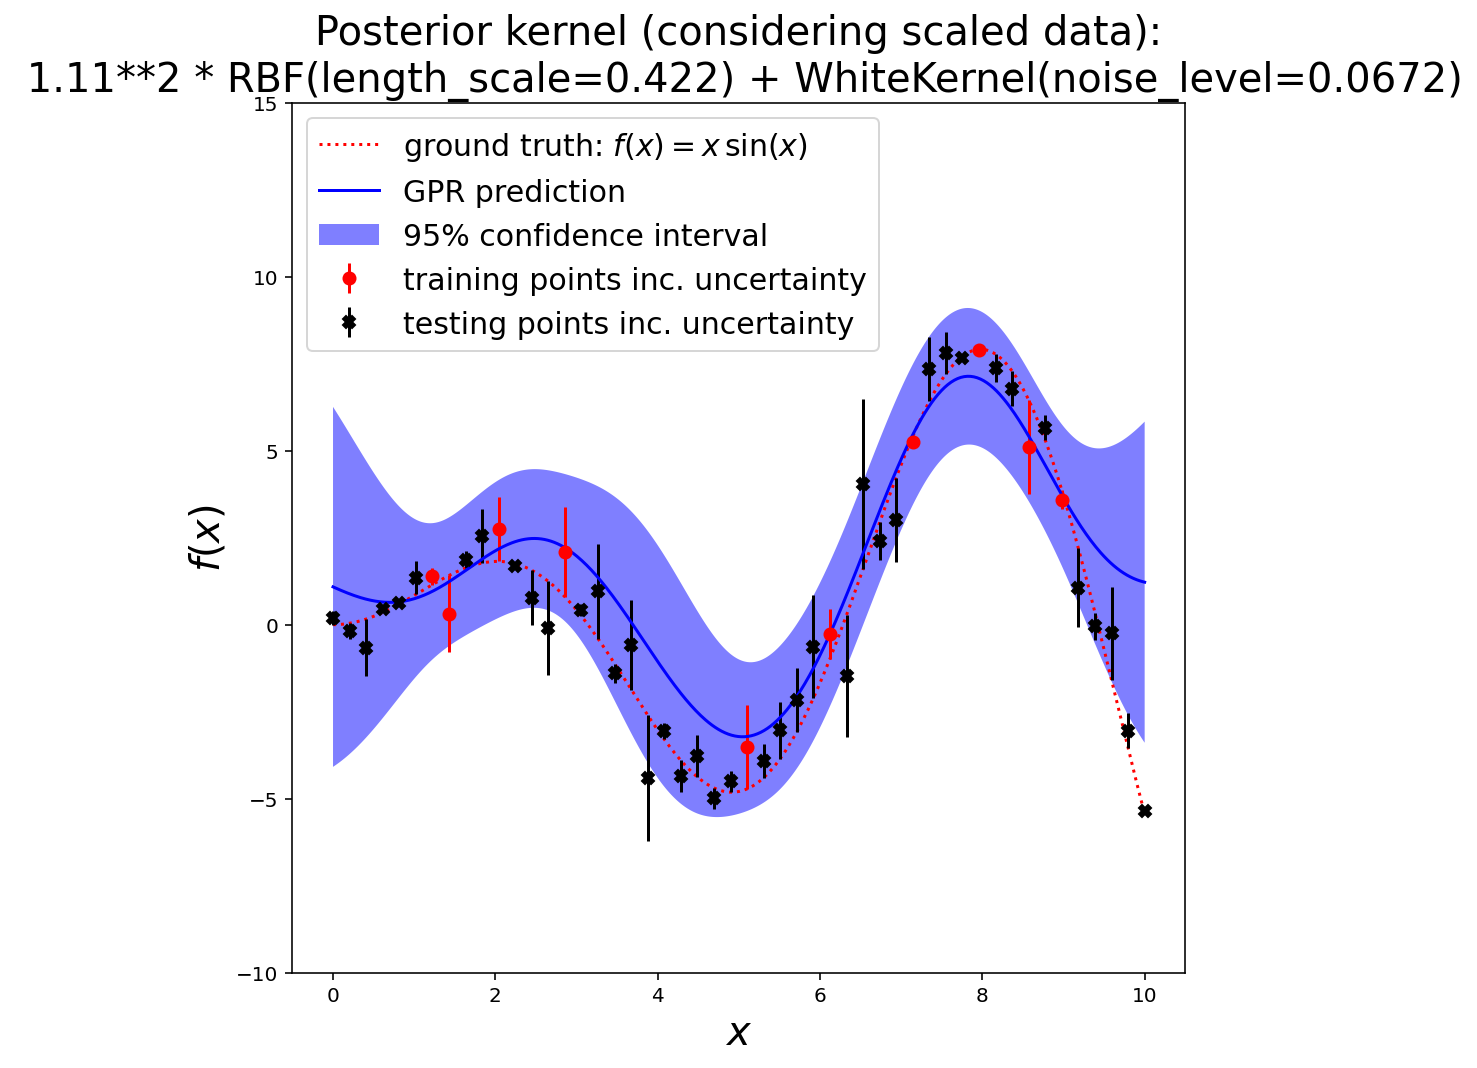

In [3]:
fig1

In [4]:
from matplotlib.colors import LogNorm
from matplotlib import cm # to change colors of surface plots
# Set the color scheme used in every plot:
set_cm = cm.cool # viridis, inferno, copper, PuBu, cool, coolwarm, hsv

length_scale = np.logspace(-2, 3, num=50)
noise_level = np.logspace(-4, 1, num=50)
length_scale_grid, noise_level_grid = np.meshgrid(length_scale, noise_level)

log_marginal_likelihood = [
    gp_model.log_marginal_likelihood(theta=np.log([0.36, scale, noise]))
    for scale, noise in zip(length_scale_grid.ravel(), noise_level_grid.ravel())
]
log_marginal_likelihood = np.reshape(
    log_marginal_likelihood, newshape=noise_level_grid.shape
)

vmin, vmax = (-log_marginal_likelihood).min(), 50
level = np.around(np.logspace(np.log10(vmin), np.log10(vmax), num=50), decimals=1)

fig2, ax2 = plt.subplots() # This opens a new figure
cset = ax2.contour(
    length_scale_grid,
    noise_level_grid,
    -log_marginal_likelihood,
    levels=level,
    norm=LogNorm(vmin=vmin, vmax=vmax), cmap=set_cm
)
fig2.colorbar(cset, ax=ax2)
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_xlabel("Length-scale", fontsize=15)
ax2.set_ylabel("Noise-level", fontsize=15)
ax2.set_title("Negative Log-marginal-likelihood\n(Look for minimum point)", fontsize=20)
fig2.set_size_inches(8,8)
plt.close(fig2)

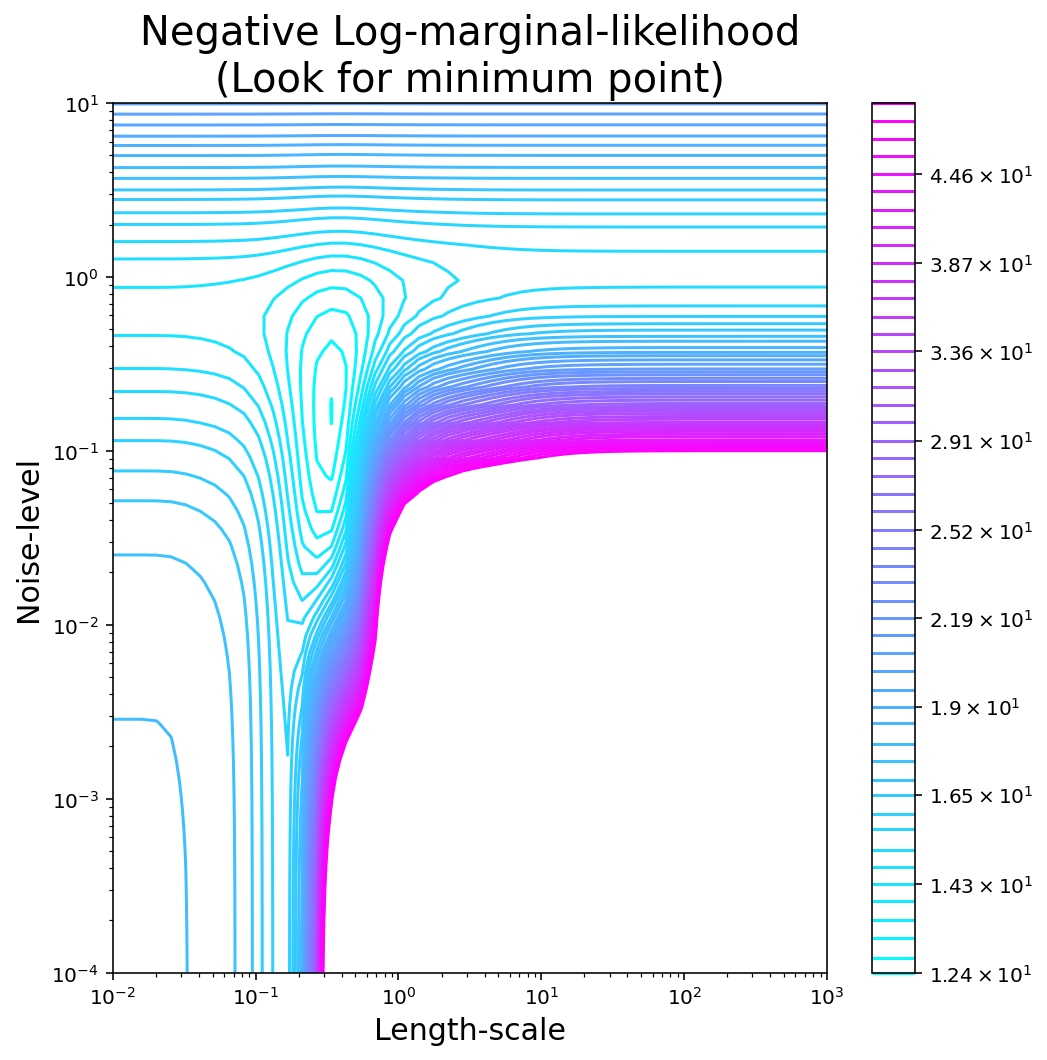

In [5]:
fig2 # plot log marginal likelihood for different hyperparameters

### In-class Exercise

Go back to this [cell](##increase_training_data) and plot a few more times the log marginal likelihood considering different number of training points (change the 'testset_ratio' value).

* Consider testset_ratio = 0.94, i.e. very few training points
    - You can see that the quality of the approximation is bad, but you should relate that to the landscape of the log marginal likelihood.

* Observe what happens as you increase the number of training points (e.g. testset_ratio = 0.80 and testset_ratio = 0.50)
    - As you increase the number of training points the optimum point becomes sharper, and easier to find.

### See you next class

Have fun!